In [137]:
from astropy.io import fits
import sys, os
from os.path import dirname, abspath, join
from datetime import datetime
from astropy.coordinates import Angle, SkyCoord, Latitude, Longitude
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import ICRS, FK5
from pytz import UTC
from alora.config import config, observatory_location
import matplotlib.pyplot as plt
import numpy as np

from alora.astroutils.observing_utils import wrap_around
from alora.config import config

POINTING_DIR = r"D:\Data\pointing_models\2024_12_26"
INFILE = [join(POINTING_DIR,f) for f in os.listdir(POINTING_DIR) if f.endswith("dat")][0]
INFILE
fitsfiles = [join(POINTING_DIR,"imgs",f) for f in os.listdir(join(POINTING_DIR,"imgs")) if f.endswith("fit")]
with fits.open(fitsfiles[0]) as hdul:
    DATE = datetime.strptime(hdul[0].header["DATE-OBS"],"%Y-%m-%dT%H:%M:%S.%f")

In [138]:
datestr = DATE.strftime("%D")

In [139]:
def savefig(fname):
    outname = join(POINTING_DIR,fname)
    plt.savefig(outname,bbox_inches="tight",dpi=300)

In [140]:
t_ras, t_decs = [], []
ras, decs = [], []
lsts = []
with open(INFILE,"r") as f:
    for i in range(5):
        f.readline()
    for line in f.readlines():
        l = [c for c in line.split(" ") if c]
        ra = Angle(" ".join(l[:3]),unit="hourangle").deg
        dec = Angle(" ".join(l[3:6]),unit="deg").deg
        t_ra = Angle(" ".join(l[6:9]),unit="hourangle").deg
        t_dec = Angle(" ".join(l[9:12]),unit="deg").deg
        # print(" ".join(l[12:14]))
        lst = Angle(" ".join(l[12:14]),unit="hourangle").deg

        t_ras.append(t_ra)
        t_decs.append(t_dec)

        ras.append(ra)
        decs.append(dec)
        lsts.append(lst)
t_ras = np.array(t_ras)
t_decs = np.array(t_decs)
ras = np.array(ras)
decs = np.array(decs)
lsts = np.array(lsts)

In [141]:
has = wrap_around(lsts-ras)

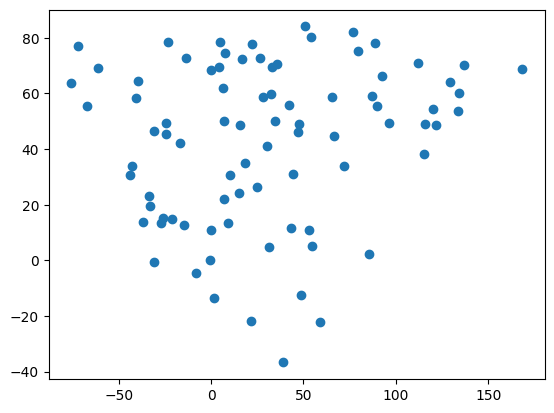

In [142]:
plt.scatter(wrap_around(lst-ras),decs)

In [143]:
dra = (ras - t_ras)*60
ddec = (decs - t_decs)*60

In [144]:
NBINS = 25

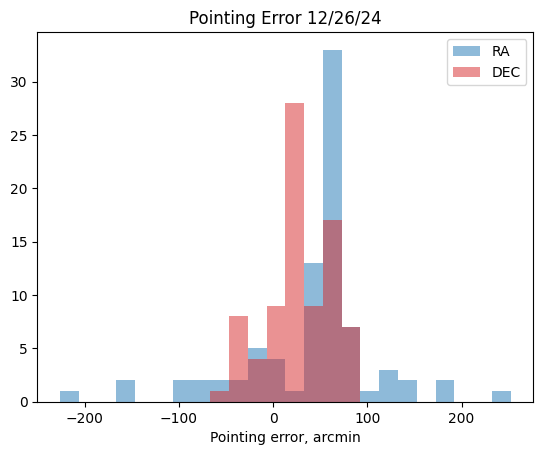

In [145]:
bins = np.linspace(min(dra),max(dra),NBINS)
plt.hist(dra,bins=bins,color="tab:blue",alpha=0.5,label="RA")
plt.hist(ddec,bins=bins,color="tab:red",alpha=0.5,label="DEC")
plt.legend()
plt.title("Pointing Error "+datestr)
plt.xlabel("Pointing error, arcmin")
savefig("error_hist.png")

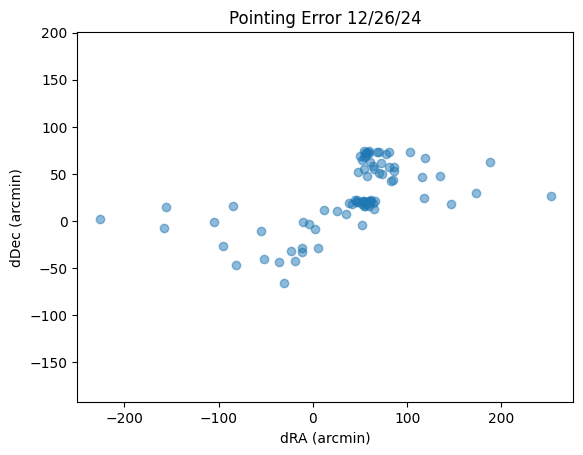

In [146]:
plt.scatter(dra,ddec,alpha=0.5)
plt.axis("equal")
plt.title("Pointing Error "+datestr)
plt.xlabel("dRA (arcmin)")
plt.ylabel("dDec (arcmin)")
savefig("scatter.png")

In [147]:
dra_mean, dra_med, dra_std =  np.mean(dra),np.median(dra),np.std(dra)
dra_mean, dra_med, dra_std

(np.float64(41.0087015060242),
 np.float64(55.41332499999996),
 np.float64(71.3388912472927))

In [148]:
ddec_mean, ddec_med, ddec_std =  np.mean(ddec),np.median(ddec),np.std(ddec)
ddec_mean, ddec_med, ddec_std

(np.float64(26.968839959839354),
 np.float64(21.278976666666836),
 np.float64(34.464715418243664))

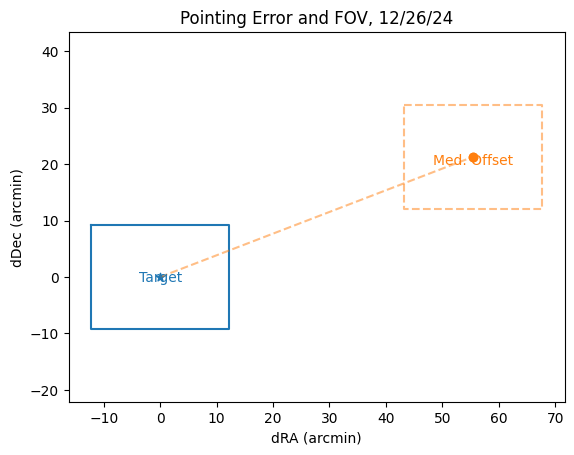

In [149]:
h = config["CAMERA"]["FIELD_HEIGHT"]
w = config["CAMERA"]["FIELD_WIDTH"]

box = np.array([(-w/2,h/2),(w/2,h/2),(w/2,-h/2),(-w/2,-h/2),(-w/2,h/2)])
plt.plot(box[:,0],box[:,1])
plt.scatter(0,0,marker="*")
plt.text(0,-0.05*h,"Target",horizontalalignment="center",color="tab:blue")
# plt.scatter(dra_mean,ddec_mean)
plt.scatter(dra_med,ddec_med,color="tab:orange")
plt.plot((0,dra_med),(0,ddec_med),alpha=0.5,linestyle="dashed",color="tab:orange")
# plt.plot(box[:,0]+dra_mean,box[:,1]+ddec_mean,alpha=0.5,linestyle="dashed")
plt.plot(box[:,0]+dra_med,box[:,1]+ddec_med,alpha=0.5,linestyle="dashed",color="tab:orange")

plt.text(dra_med,ddec_med-0.08*h,"Med. Offset",horizontalalignment="center",color="tab:orange")

plt.axis("equal")
plt.scatter(dra_med,ddec_med)
plt.xlabel("dRA (arcmin)")
plt.ylabel("dDec (arcmin)")
plt.title("Pointing Error and FOV, "+datestr)
savefig("fields.png")

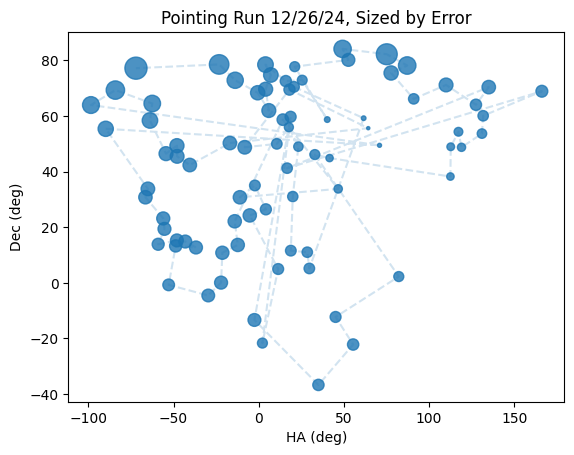

In [150]:
plt.scatter(has,decs,s=np.sqrt(dra**2 + ddec**2),alpha=0.8)
plt.plot(has,decs,linestyle="dashed",alpha=0.2)
plt.title(f"Pointing Run {datestr}, Sized by Error")
plt.xlabel("HA (deg)")
plt.ylabel("Dec (deg)")
savefig("spatial.png")